<h3>05. 소프트맥스 회귀로 MNIST 데이터 분류하기</h3>


<h4>2.토치비전 소개하기</h4>

본격적인 실습에 들어가기에 앞서 토치비전(torchvision)이라는 도구를 설명하겠습니다. torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지입니다. 아래의 링크는 torchvision에 어떤 데이터셋들(datasets)과 모델들(models) 그리고 어떤 전처리 방법들(transforms)을 제공하고 있는지 보여줍니다.




<h4>3. 분류기 구현을 위한 사전 설정</h4>

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)


다음 기기로 학습합니다: cpu


In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# hyperparameters
training_epochs = 15
batch_size = 100

<h4>4. Minist 분류기 구현하기</h4>

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

9913344it [00:00, 19245403.32it/s]                             


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



29696it [00:00, 33214413.76it/s]         

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




1649664it [00:00, 10540383.08it/s]                           


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



5120it [00:00, 24237964.42it/s]         

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1643987637853/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로입니다. 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받습니다. 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해줍니다. 네번째 인자 download는 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미입니다.

In [6]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

이때 DataLoader에는 4개의 인자가 있습니다. 첫번째 인자인 dataset은 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미합니다.

- drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [7]:
linear = nn.Linear(784,10 , bias=True).to(device)

to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.

bias는 편향 b를 사용할 것인지를 나타냅니다. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었습니다.

In [8]:
#비용함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device)#내부적으로 소프트맥스 함수를 포함함
optimizer = torch.optim.SGD(linear.parameters(),lr=0.1)


- 앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X,Y in data_loader:
        #배치 크기가 100이므로 아래의 연산에서 X는 (100,784)의 텐서가 된다
        X = X.view(-1,28*28).to(device) #784의 텐서로 변경
        #레이블은 원-핫 인코딩이 된 상태가 아니라 0~ 9 의 정수
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis,Y)
        cost.backward()
        optimizer.step()

        avg_cost+= cost/total_batch

    
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
print('learning 끝')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307107031
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956169
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515589
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526860
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874764
Epoch: 0015 cost = 0.274422735
learning 끝


Accuracy: 0.8883000016212463
Label:  7
Prediction:  7


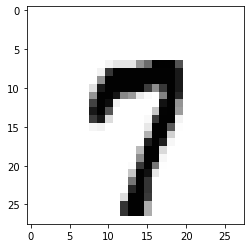

In [13]:
#테스트 데이터를 사용해 모델 테스트
with torch.no_grad(): # torch.no_grad()를 사용하면 gradient계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1,28*28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction=linear(X_test)
    correct_prediction = torch.argmax(prediction,1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()